In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

import functions.eddy_feedback as ef

In [2]:
directory_path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded')

# Initialize an empty list to store the model names
model_names = []
# Iterate through the files in the directory
for file in directory_path.iterdir():
    if file.is_file() and file.suffix == ".nc":
        # Extract the stem (filename without extension)
        filename_stem = file.stem
        # Split by underscore and take the first part (MODEL)
        model_name = filename_stem.split('_')[0]
        # Append the model name to the list
        model_names.append(model_name)
        
# sort the models alphabetically
model_names.sort()
model_names.remove('E3SMv1')
model_names.remove('ECHAM6.3')
# model_names

In [3]:
ds_models = {}
for model in model_names:
    
    # set file directory
    file_dir = directory_path.glob(f'{model}*.nc')
    # import data
    dataset = xr.open_mfdataset(
        file_dir,
        parallel=True
    )
    
    # subset data
    dataset = dataset.where(dataset.level < 1000.)
    dataset = dataset.where(dataset.lat < 90.)
    
    # save to dictionary
    ds_models[model] = dataset
    
# del ds_models['E3SMv1']
# del ds_models['ECHAM6.3']
len(ds_models)

13

In [4]:
model_efp_res = {}
for model in model_names:
    
    # calculate EFP
    efp_nh = ef.calculate_efp(ds_models[model], data_type='pamip')
    efp_sh = ef.calculate_efp(ds_models[model], data_type='pamip', calc_south_hemis=True)
    
    # calculate each model res
    resolution = abs(ds_models[model].lat[0] - ds_models[model].lat[1])
    
    model_efp_res[model] = (resolution.values.item(), efp_nh, efp_sh)
    
# del model_efp_res['CESM1-WACCM-SC']
# del model_efp_res['CanESM5']
# del model_efp_res['NorESM2-LM']

# Seaborn plot

In [5]:
# Convert to DataFrame
df = pd.DataFrame([
    {"Model": model, "NH EFP Value": values[1], "SH EFP Value": values[2], "Calculated Resolution": values[0]} 
    for model, values in model_efp_res.items()
])
df

,Model,NH EFP Value,SH EFP Value,Calculated Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737
1,CESM2,0.3693,0.3419,0.942408
2,CNRM-CM6-1,0.2421,0.2082,1.389030
3,CanESM5,0.4256,0.4618,2.767272
4,EC-EARTH3,0.2945,0.3135,0.695870
5,FGOALS-f3-L,0.2354,0.1274,1.000000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609
9,MIROC6,0.2213,0.3253,1.389030


In [6]:
# correct resolution values
correct_res = {
    'CESM2': 1.25,
    'CanESM5': 2.8,
    'CNRM-CM6-1': 1.0,
    'E3SMv1': 1.0,
    'EC-EARTH3': 1.0,
    'ECHAM6.3': 0.94,
    'FGOALS-f3-L': 1.0,
    'HadGEM3-GC31-MM': 0.55,
    'HadGEM3-GC31-LL': 1.25,
    'IPSL-CM6A-LR': 1.26,
    'MIROC6': 1.4,
    'NorESM2-LM': 1.9,
    'OpenIFS-159': 1.125,
    'OpenIFS-511': 0.352,
    'OpenIFS-1279': 0.14,
    'CESM1-WACCM-SC': 1.9
}

# Convert to DataFrame
res_df = pd.DataFrame([
    {"Model": model, "Latitude Resolution": res}
    for model, res in correct_res.items()
])

# Merge on 'Model'
merged_df = df.merge(res_df, on="Model", how="left")
df = merged_df
df

,Model,NH EFP Value,SH EFP Value,Calculated Resolution,Latitude Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737,1.900
1,CESM2,0.3693,0.3419,0.942408,1.250
2,CNRM-CM6-1,0.2421,0.2082,1.389030,1.000
3,CanESM5,0.4256,0.4618,2.767272,2.800
4,EC-EARTH3,0.2945,0.3135,0.695870,1.000
5,FGOALS-f3-L,0.2354,0.1274,1.000000,1.000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000,1.250
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557,0.550
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609,1.260
9,MIROC6,0.2213,0.3253,1.389030,1.400


Watch out for incorrect resolution with OpenIFS-511!!

### Drop some models, if required

In [7]:
# df = df.drop(index=0) # drop CESM1
# df = df.drop(index=3) # drop CanESM5
# df = df.drop(index=10) # drop NorESM2
df = df.drop(index=12) # drop OpenIFS-511
df

,Model,NH EFP Value,SH EFP Value,Calculated Resolution,Latitude Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737,1.900
1,CESM2,0.3693,0.3419,0.942408,1.250
2,CNRM-CM6-1,0.2421,0.2082,1.389030,1.000
3,CanESM5,0.4256,0.4618,2.767272,2.800
4,EC-EARTH3,0.2945,0.3135,0.695870,1.000
5,FGOALS-f3-L,0.2354,0.1274,1.000000,1.000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000,1.250
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557,0.550
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609,1.260
9,MIROC6,0.2213,0.3253,1.389030,1.400


# Both Hemispheres

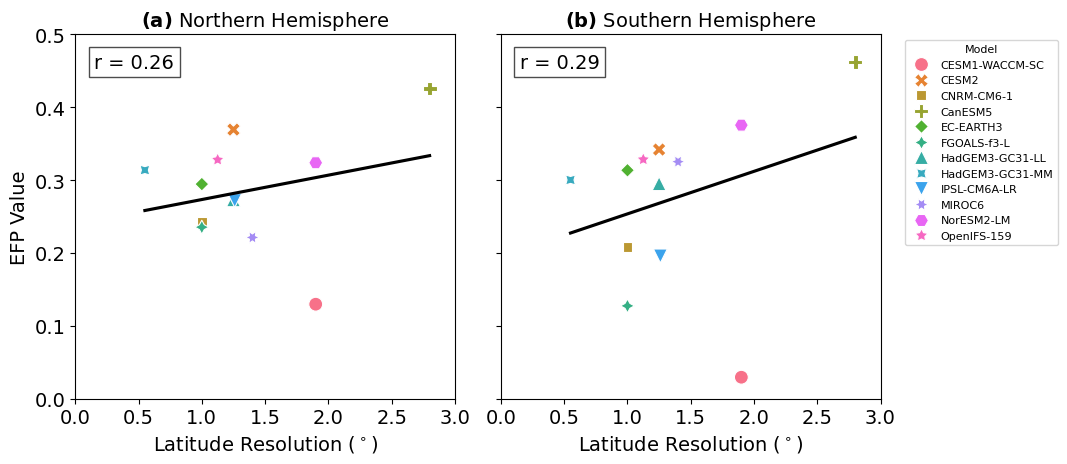

In [8]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

# First plot: NH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df["Latitude Resolution"], 
    y=df["NH EFP Value"], 
    hue=df["Model"], 
    style=df["Model"], 
    ax=axes[0], 
    s=100
)
sns.regplot(
    x=df["Latitude Resolution"], 
    y=df["NH EFP Value"], 
    scatter=False, 
    ax=axes[0], 
    color="black", 
    ci=None
)
axes[0].set_title("$\\bf{(a)}$ Northern Hemisphere", fontsize=14)
axes[0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0].set_ylabel("EFP Value", fontsize=14)
axes[0].set_xlim(0,3)
axes[0].set_ylim(0,0.5)
axes[0].tick_params(labelsize=14)
axes[0].get_legend().remove()
add_correlation(axes[0], df["Latitude Resolution"], df["NH EFP Value"])

# Second plot: SH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df["Latitude Resolution"], 
    y=df["SH EFP Value"], 
    hue=df["Model"], 
    style=df["Model"], 
    ax=axes[1], 
    s=100
)
sns.regplot(
    x=df["Latitude Resolution"], 
    y=df["SH EFP Value"], 
    scatter=False, 
    ax=axes[1], 
    color="black", 
    ci=None
)
axes[1].set_title("$\\bf{(b)}$ Southern Hemisphere", fontsize=14)
axes[1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1].set_xlim(0,3)
axes[1].set_ylim(0,0.5)
axes[1].tick_params(labelsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, 
               title='Model', title_fontsize=8)
add_correlation(axes[1], df["Latitude Resolution"], df["SH EFP Value"])

# Suptitle slightly left-aligned
# fig.suptitle("PAMIP EFP Values vs Model Resolution", fontsize=16, x=0.4)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for legend and suptitle
plt.show()


# Subset dataset

In [9]:
# df2 = df.drop(index=0) # drop CESM1
df2 = df.drop(index=3) # drop CanESM5
# df2 = df2.drop(index=10) # drop NorESM2
df2

,Model,NH EFP Value,SH EFP Value,Calculated Resolution,Latitude Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737,1.900
1,CESM2,0.3693,0.3419,0.942408,1.250
2,CNRM-CM6-1,0.2421,0.2082,1.389030,1.000
4,EC-EARTH3,0.2945,0.3135,0.695870,1.000
5,FGOALS-f3-L,0.2354,0.1274,1.000000,1.000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000,1.250
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557,0.550
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609,1.260
9,MIROC6,0.2213,0.3253,1.389030,1.400
10,NorESM2-LM,0.3238,0.3754,1.894737,1.900


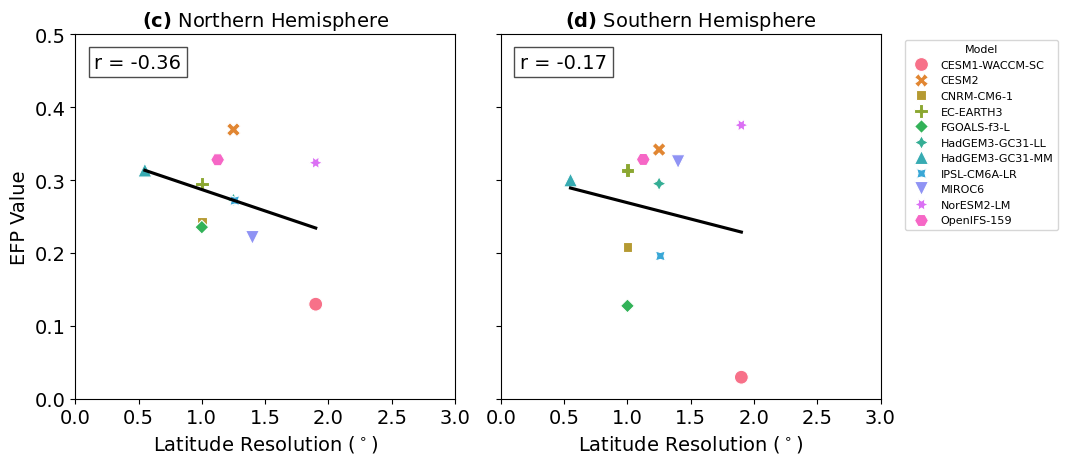

In [10]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

# First plot: NH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df2["Latitude Resolution"], 
    y=df2["NH EFP Value"], 
    hue=df2["Model"], 
    style=df2["Model"], 
    ax=axes[0], 
    s=100
)
sns.regplot(
    x=df2["Latitude Resolution"], 
    y=df2["NH EFP Value"], 
    scatter=False, 
    ax=axes[0], 
    color="black", 
    ci=None
)
axes[0].set_title("$\\bf{(c)}$ Northern Hemisphere", fontsize=14)
axes[0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0].set_ylabel("EFP Value", fontsize=14)
axes[0].set_xlim(0,3)
axes[0].set_ylim(0,0.5)
axes[0].tick_params(labelsize=14)
axes[0].get_legend().remove()
add_correlation(axes[0], df2["Latitude Resolution"], df2["NH EFP Value"])

# Second plot: SH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df2["Latitude Resolution"], 
    y=df2["SH EFP Value"], 
    hue=df2["Model"], 
    style=df2["Model"], 
    ax=axes[1], 
    s=100
)
sns.regplot(
    x=df2["Latitude Resolution"], 
    y=df2["SH EFP Value"], 
    scatter=False, 
    ax=axes[1], 
    color="black", 
    ci=None
)
axes[1].set_title("$\\bf{(d)}$ Southern Hemisphere", fontsize=14)
axes[1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1].set_xlim(0,3)
axes[1].set_ylim(0,0.5)
axes[1].tick_params(labelsize=14)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8,
               title='Model', title_fontsize=8)
add_correlation(axes[1], df2["Latitude Resolution"], df2["SH EFP Value"])

# Suptitle slightly left-aligned
# fig.suptitle("PAMIP EFP Values vs Model Resolution", fontsize=16, x=0.4)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for legend and suptitle
plt.show()

# Combined

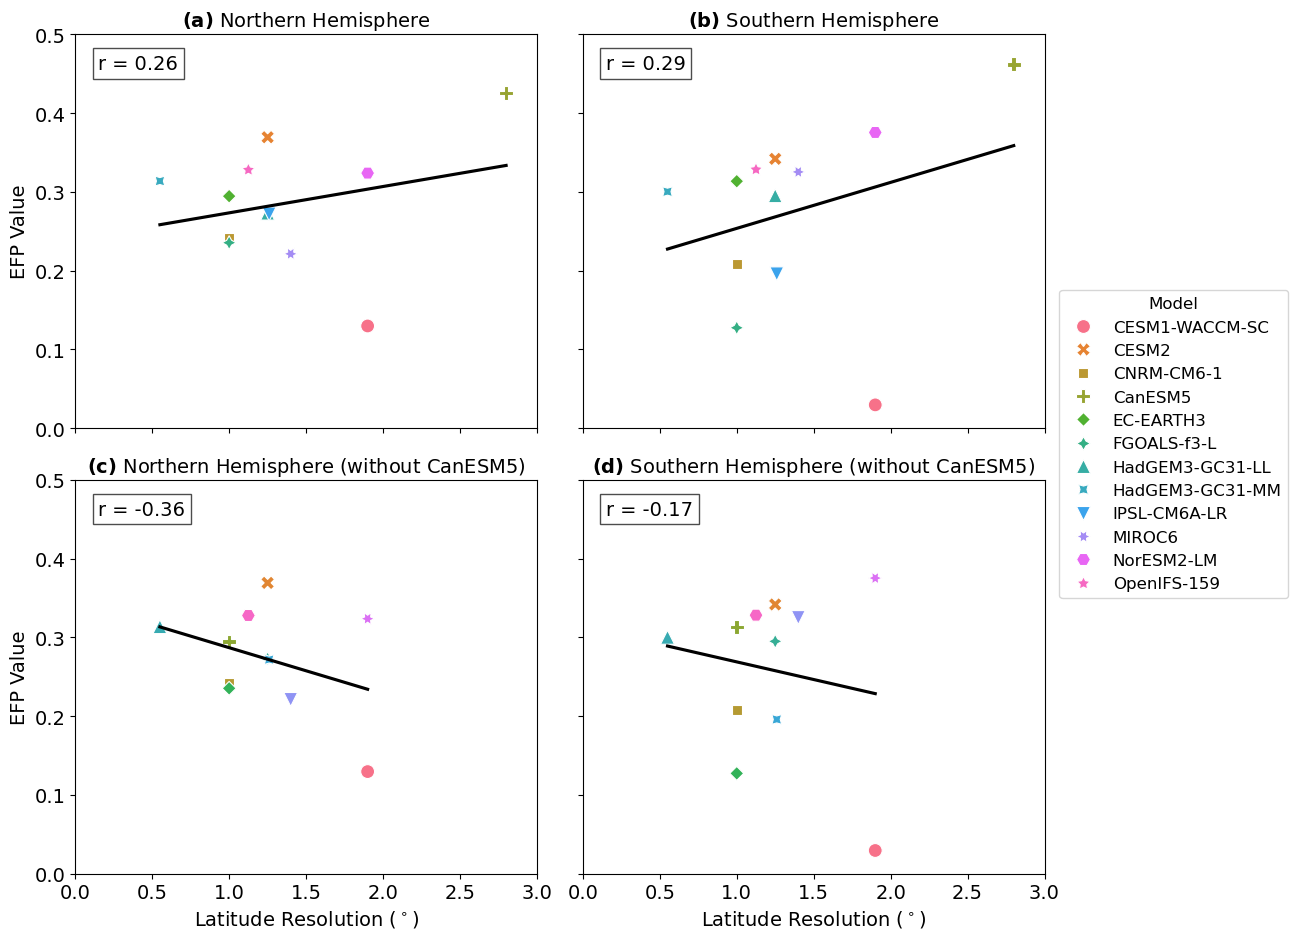

In [11]:
# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)  # 1 row, 2 columns

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))
    
# TOP ROW
#------------------------------------------------------------

# First plot: NH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df["Latitude Resolution"], 
    y=df["NH EFP Value"], 
    hue=df["Model"], 
    style=df["Model"], 
    ax=axes[0,0], 
    s=100
)
sns.regplot(
    x=df["Latitude Resolution"], 
    y=df["NH EFP Value"], 
    scatter=False, 
    ax=axes[0,0], 
    color="black", 
    ci=None
)
axes[0,0].set_title("$\\bf{(a)}$ Northern Hemisphere", fontsize=14)
axes[0,0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0,0].set_ylabel("EFP Value", fontsize=14)
axes[0,0].set_xlim(0,3)
axes[0,0].set_ylim(0,0.5)
axes[0,0].tick_params(labelsize=14)
axes[0,0].get_legend().remove()
add_correlation(axes[0,0], df["Latitude Resolution"], df["NH EFP Value"])

# Second plot: SH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df["Latitude Resolution"], 
    y=df["SH EFP Value"], 
    hue=df["Model"], 
    style=df["Model"], 
    ax=axes[0,1], 
    s=100
)
sns.regplot(
    x=df["Latitude Resolution"], 
    y=df["SH EFP Value"], 
    scatter=False, 
    ax=axes[0,1], 
    color="black", 
    ci=None
)
axes[0,1].set_title("$\\bf{(b)}$ Southern Hemisphere", fontsize=14)
axes[0,1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0,1].set_xlim(0,3)
axes[0,1].set_ylim(0,0.5)
axes[0,1].tick_params(labelsize=14)
axes[0,1].legend().remove()
add_correlation(axes[0,1], df["Latitude Resolution"], df["SH EFP Value"])

# BOTTOM ROW
#------------------------------------------------------------

# First plot: NH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df2["Latitude Resolution"], 
    y=df2["NH EFP Value"], 
    hue=df2["Model"], 
    style=df2["Model"], 
    ax=axes[1,0], 
    s=100
)
sns.regplot(
    x=df2["Latitude Resolution"], 
    y=df2["NH EFP Value"], 
    scatter=False, 
    ax=axes[1,0], 
    color="black", 
    ci=None
)
axes[1,0].set_title("$\\bf{(c)}$ Northern Hemisphere (without CanESM5)", fontsize=14)
axes[1,0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1,0].set_ylabel("EFP Value", fontsize=14)
axes[1,0].set_xlim(0,3)
axes[1,0].set_ylim(0,0.5)
axes[1,0].tick_params(labelsize=14)
axes[1,0].get_legend().remove()
add_correlation(axes[1,0], df2["Latitude Resolution"], df2["NH EFP Value"])

# Second plot: SH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df2["Latitude Resolution"], 
    y=df2["SH EFP Value"], 
    hue=df2["Model"], 
    style=df2["Model"], 
    ax=axes[1,1], 
    s=100
)
sns.regplot(
    x=df2["Latitude Resolution"], 
    y=df2["SH EFP Value"], 
    scatter=False, 
    ax=axes[1,1], 
    color="black", 
    ci=None
)
axes[1,1].set_title("$\\bf{(d)}$ Southern Hemisphere (without CanESM5)", fontsize=14)
axes[1,1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1,1].set_xlim(0,3)
axes[1,1].set_ylim(0,0.5)
axes[1,1].tick_params(labelsize=14)
axes[1,1].get_legend().remove()
add_correlation(axes[1,1], df2["Latitude Resolution"], df2["SH EFP Value"])

# Get handles and labels from one of the plots
handles, labels = axes[0,1].get_legend_handles_labels()

# Add a figure-level legend, centered vertically on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.88, 0.5),
           fontsize=12, title='Model', title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for legend and suptitle
plt.show()


# Poster plot

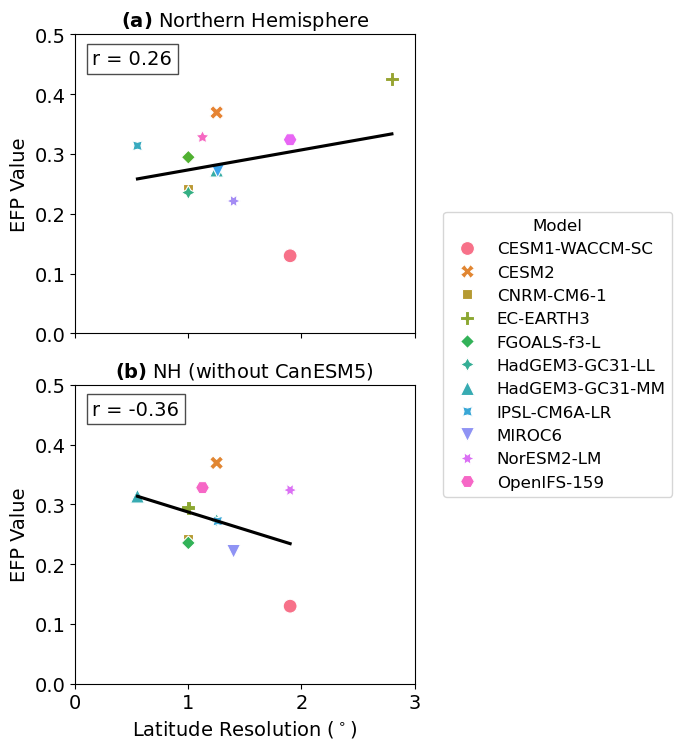

In [12]:
# Create figure and subplots
fig, axes = plt.subplots(nrows=2, figsize=(5, 8), sharey=True, sharex=True)  # 1 row, 2 columns

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))
    
# TOP ROW
#------------------------------------------------------------

# First plot: NH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df["Latitude Resolution"], 
    y=df["NH EFP Value"], 
    hue=df["Model"], 
    style=df["Model"], 
    ax=axes[0], 
    s=100
)
sns.regplot(
    x=df["Latitude Resolution"], 
    y=df["NH EFP Value"], 
    scatter=False, 
    ax=axes[0], 
    color="black", 
    ci=None
)
axes[0].set_title("$\\bf{(a)}$ Northern Hemisphere", fontsize=14)
axes[0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0].set_ylabel("EFP Value", fontsize=14)
axes[0].set_xlim(0,3)
axes[0].set_ylim(0, .5)
axes[0].tick_params(labelsize=14)
axes[0].get_legend().remove()
add_correlation(axes[0], df["Latitude Resolution"], df["NH EFP Value"])

# BOTTOM ROW
#------------------------------------------------------------

# First plot: NH EFP vs. Latitude Resolution
sns.scatterplot(
    x=df2["Latitude Resolution"], 
    y=df2["NH EFP Value"], 
    hue=df2["Model"], 
    style=df2["Model"], 
    ax=axes[1], 
    s=100
)
sns.regplot(
    x=df2["Latitude Resolution"], 
    y=df2["NH EFP Value"], 
    scatter=False, 
    ax=axes[1], 
    color="black", 
    ci=None
)
axes[1].set_title("$\\bf{(b)}$ NH (without CanESM5)", fontsize=14)
axes[1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1].set_ylabel("EFP Value", fontsize=14)
axes[1].set_xlim(0,3)
axes[1].set_ylim(0, .5)
axes[1].tick_params(labelsize=14)
axes[1].get_legend().remove()
add_correlation(axes[1], df2["Latitude Resolution"], df2["NH EFP Value"])

# Get handles and labels from one of the plots
handles, labels = axes[1].get_legend_handles_labels()

# Add a figure-level legend, centered vertically on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.88, 0.5),
           fontsize=12, title='Model', title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for legend and suptitle
plt.show()
